In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr

In [30]:
apple = yf.Ticker('AAPL')
apple = apple.history(period='max')
apple

#Rate limit API problem

Failed to get ticker 'AAPL' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/AAPL?range=1d&interval=1d&crumb=QBdHmYObldM (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000017813F53450>, 'Connection to query2.finance.yahoo.com timed out. (connect timeout=10)'))
$AAPL: possibly delisted; no timezone found


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [33]:
data = pdr.get_data_stooq('AAPL')

data.to_csv('apple_stock.csv', encoding='utf-8')

In [34]:
data.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2024-10-31,229.34,229.830,225.37,225.91,64370086.0
2024-10-30,232.61,233.470,229.55,230.10,47070907.0
2024-10-29,233.10,234.325,232.32,233.67,35417247.0
2024-10-28,233.32,234.730,232.55,233.40,36087134.0
2024-10-25,229.74,233.220,229.57,231.41,38802304.0


In [35]:
data.index

DatetimeIndex(['2024-10-31', '2024-10-30', '2024-10-29', '2024-10-28',
               '2024-10-25', '2024-10-24', '2024-10-23', '2024-10-22',
               '2024-10-21', '2024-10-18',
               ...
               '2019-11-15', '2019-11-14', '2019-11-13', '2019-11-12',
               '2019-11-11', '2019-11-08', '2019-11-07', '2019-11-06',
               '2019-11-05', '2019-11-04'],
              dtype='datetime64[ns]', name='Date', length=1257, freq=None)

<Axes: xlabel='Date'>

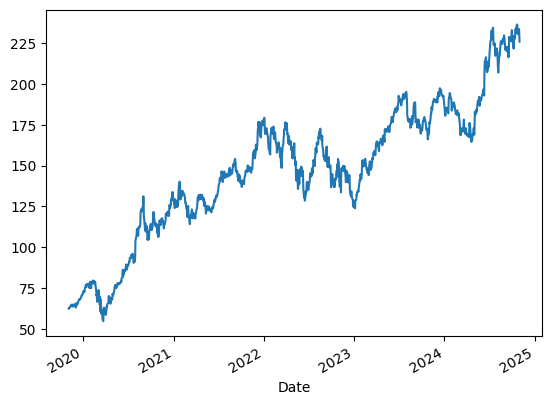

In [36]:
data['Close'].plot()

In [37]:
#Target is whether tomorrow's close is higher than today's close
data['tomorrow'] = data['Close'].shift(-1)

data['target'] = (data['tomorrow'] > data['Close']).astype(int)

In [38]:
data.sample(10)

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
2023-11-20,189.1720,191.1790,189.1620,190.7260,4.671521e+07,188.9720,0
2023-01-06,124.8360,129.0760,123.7270,128.4120,8.858008e+07,123.8560,0
2021-11-12,146.1950,148.1410,145.2570,147.7360,6.477789e+07,145.6400,0
2022-10-24,145.5710,148.5830,144.4000,147.8120,7.682378e+07,145.6550,0
2019-11-07,62.7803,63.1695,62.6281,62.9492,9.782125e+07,62.2281,0
2022-09-15,152.9550,153.5400,149.7220,150.7000,9.148362e+07,153.6080,1
2020-12-03,120.9210,121.1780,119.6380,120.3480,8.066722e+07,120.4860,1
2021-08-27,145.0480,146.2940,144.4170,146.1470,5.673682e+07,145.0980,0
2020-08-26,123.3110,124.1100,122.2240,123.6460,1.668182e+08,121.9770,0


In [39]:
data['target'].value_counts()

target
0    673
1    584
Name: count, dtype: int64

MODEL DEVELOPMENT

In [40]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import precision_score

In [41]:
predictors = ['Open', 'High', 'Low', 'Close', 'Volume']

train = data.iloc[:-200]
test = data.iloc[-200:]

In [42]:
print(train.shape)
print(test.shape)

(1057, 7)
(200, 7)


In [43]:
#Test different estimators to obtain the best.

model_params = {
    "knn" : {
        "model" : KNeighborsClassifier(n_jobs=2),
        "params" : {
            "n_neighbors" : [5,10, 15],
            "leaf_size" : [15, 20, 30,40],
            "weights" : ['uniform', 'distance']
        }
    },

    "hst" : {
        "model" : HistGradientBoostingClassifier(random_state=42),
        "params" : {
            "max_iter" : [75, 100, 150, 200],
            "max_depth" : [5, 10,15,20],
            "max_features" : [0.2, 0.5, 0.7, 1.0],
            "min_samples_leaf": [10,15,20,30]
        }
    },

    "rfc" :{
        "model" : RandomForestClassifier(random_state=42, n_jobs=2, class_weight='balanced'),
        "params" : {
            "n_estimators" : [50, 100, 200, 300],
            "max_depth": [5,10,15,20],
            "max_leaf_nodes": [2,5,7],
            "min_samples_leaf": [2,4,7,10]
        }
    }
}

In [44]:
tscv = TimeSeriesSplit(n_splits=5)

scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=tscv, return_train_score=True)
    clf.fit(train[predictors], train['target'])
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })


C:\Users\Hp Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [51]:
scores

[{'model': 'knn',
  'best_score': 0.5204545454545454,
  'best_params': {'leaf_size': 15, 'n_neighbors': 10, 'weights': 'uniform'}},
 {'model': 'hst',
  'best_score': 0.6181818181818182,
  'best_params': {'max_depth': 5,
   'max_features': 1.0,
   'max_iter': 100,
   'min_samples_leaf': 10}},
 {'model': 'rfc',
  'best_score': 0.5579545454545455,
  'best_params': {'max_depth': 10,
   'max_leaf_nodes': 7,
   'min_samples_leaf': 4,
   'n_estimators': 50}}]

In [59]:
model = HistGradientBoostingClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

model.fit(train[predictors], train['target'])

HistGradientBoostingClassifier(max_depth=5, min_samples_leaf=10,
                               random_state=42)

In [60]:
y_preds = model.predict(test[predictors])
y_preds = pd.Series(y_preds, index=test.index)

print(f'model precision: ', precision_score(test['target'], y_preds, zero_division=1))

model precision:  0.4626865671641791


In [61]:
test['target'].value_counts()

target
0    115
1     85
Name: count, dtype: int64

In [62]:
pd.crosstab(test['target'], y_preds, rownames = ['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,43,72
1,23,62


BACKTESTING